In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import random
import math

from src.segment import egg_contours
from src.load import load_image
from src.bound_eggs import fit_ellipses

from tqdm.notebook import tqdm

# If we are using PyCharm dark mode, the image will be inverted unless we do this
plt.style.use('dark_background')

In [2]:
species = ['Hydrobates leucorhous leucorhous',
 'Buteo jamaicensis calurus',
 'Aquila chrysaetos canadensis',
 'Falco mexicanus',
 'Rallus obsoletus obsoletus',
 'Actitis macularius',
 'Chlidonias niger surinamensis',
 'Uria aalge californica',
 'Aphelocoma californica californica',
 'Campylorhynchus brunneicapillus couesi',
 'Mimus polyglottos leucopterus',
 'Toxostoma bendirei',
 'Turdus migratorius propinquus']

In [3]:
data = pd.read_csv('../data/California_Egg_Data.csv')

In [33]:
dataset = []

In [34]:
labels = []

In [35]:
for idx, row in tqdm(data.iterrows()):
    if row["SCIENTIFIC_NAME"] in species:
        dataset.append(load_image(row["IMAGE URL"]))
        labels.append(row["SCIENTIFIC_NAME"])

0it [00:00, ?it/s]

In [36]:
train_images = dataset.copy()
train_labels = labels.copy()

In [37]:
test_images = []
test_labels = []

In [38]:
for _ in range(215):
    r = random.randint(0,len(train_images))

    test_labels.append(train_labels.pop(r))
    test_images.append(train_images.pop(r))

In [44]:
train_contours = []
test_contours = []

In [45]:
for img in tqdm(train_images):
    train_contours.append(egg_contours(img))

for img in tqdm(test_images):
    test_contours.append(egg_contours(img))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

In [47]:
train_ellipses = []
test_ellipses = []

In [48]:
for contour in tqdm(train_contours):
    train_ellipses.append(fit_ellipses(contour, len(contour)))

for contour in tqdm(test_contours):
    test_ellipses.append(fit_ellipses(contour, len(contour)))

  0%|          | 0/600 [00:00<?, ?it/s]

C:\Users\benja\Code\BirdEggSpecies\src\bound_eggs.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ellipses)


  0%|          | 0/215 [00:00<?, ?it/s]

In [49]:
def get_sub_image(rect, src):
    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    m = cv2.getRotationMatrix2D( center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, m, (src.shape[1],src.shape[0]))
    out = cv2.getRectSubPix(dst, size, center)
    return out

def contours_to_imgs(img, contours, output_shape=(64,64)):
    imgs = []
    for c in contours:
        #plt.imshow(cv2.drawContours(img,[rect], -1, (255,0,0)))
        imgs.append(cv2.resize(get_sub_image(cv2.minAreaRect(c), img.copy()), output_shape))
    return imgs

In [72]:
el = contours[10]
img = dataset[10]

In [73]:
#plt.imshow(cv2.drawContours(img, el, -1, (255,255,255)))

In [74]:
t = contours_to_imgs(img, el)

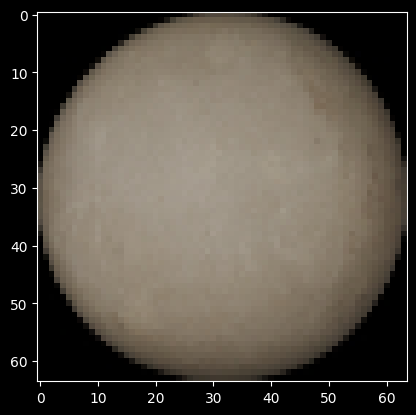

In [75]:
plt.imshow(t[0])

In [50]:
test_imgs = []
test_img_labels = []
for img, contour, label in zip(test_images, test_contours, test_labels):
    for x in contours_to_imgs(img, contour):
        test_imgs.append(x)
        test_img_labels.append(label)

In [51]:
train_imgs = []
train_img_labels = []
for img, contour, label in zip(train_images, train_contours, train_labels):
    for x in contours_to_imgs(img, contour):
        train_imgs.append(x)
        train_img_labels.append(label)

In [52]:
test_imgs = np.stack(test_imgs, axis=0)
test_img_labels = np.asarray(test_img_labels)

train_imgs = np.stack(train_imgs, axis=0)
train_img_labels = np.asarray(train_img_labels)

In [53]:
np.savez_compressed("../data/train_dataset.npz", X=train_imgs, Y=train_img_labels)
np.savez_compressed("../data/test_dataset.npz", X=test_imgs, Y=test_img_labels)

In [54]:
ftestdata = np.load("../data/train_dataset.npz", allow_pickle=True)["Y"]
ftraindata = np.load("../data/test_dataset.npz", allow_pickle=True)["Y"]

In [55]:
from sklearn.preprocessing import LabelEncoder
import pickle

encoder1 = LabelEncoder()
encoder1 = encoder1.fit(ftraindata)
with open("../data/objects/train.pkl", "wb+") as f:
    pickle.dump(encoder1, f)

encoder2 = LabelEncoder()
encoder2 = encoder2.fit(ftestdata)
with open("../data/objects/test.pkl", "wb+") as f:
    pickle.dump(encoder2, f)